In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4
import os

In [2]:
file_path = os.path.join(os.getcwd(), r"C:\Users\USER\Downloads\cs185c\gebco_japan.nc")
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()
# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

In [3]:
# define the parameters that will be used in the data file
delX = 1/10
delY = 1/15
xgOrigin = 125
ygOrigin = 20
n_rows = 450
n_cols = 300

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

# set points on land to 0
Model_bathy[Model_bathy>0] = 0

## Visualizing The Bathymetry Grid

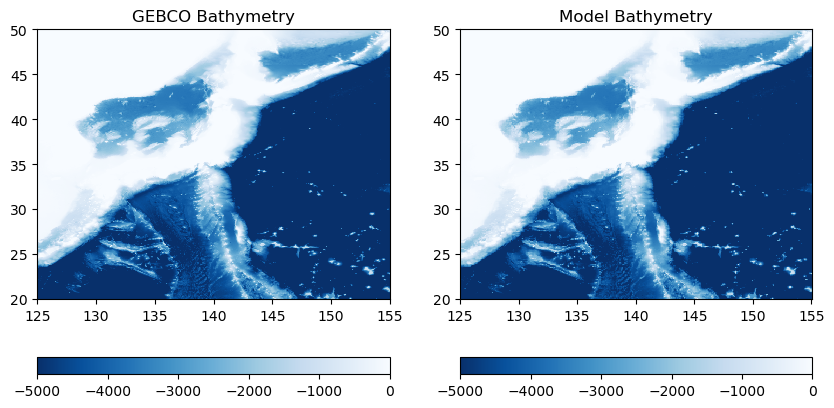

In [4]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

## Checking for isolated connected regions

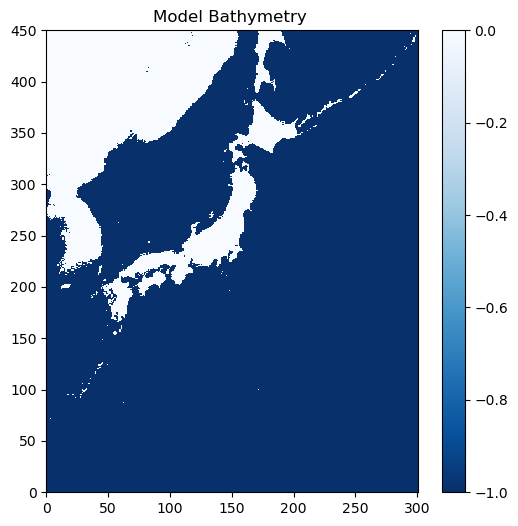

In [5]:
plt.figure(figsize=(6,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

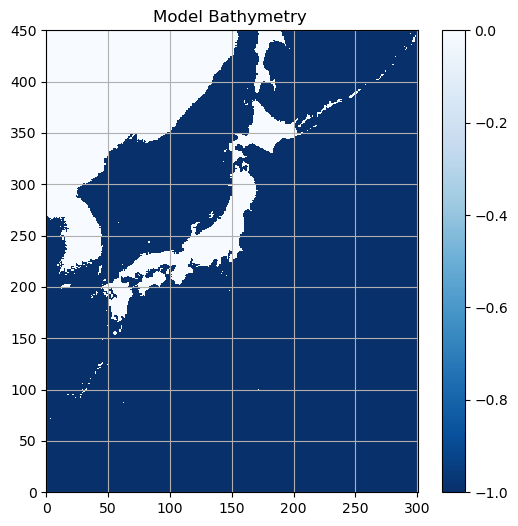

In [6]:
#Update: enclosed bathymetry, fill in the domain
#!git clone https://github.com/mhwood/eccoseas
from eccoseas.downscale import bathymetry as edb

Model_bathy = edb.fill_unconnected_model_regions(Model_bathy, central_wet_row=100, central_wet_col=100)
plt.figure(figsize=(6,6))
C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.grid()
plt.title('Model Bathymetry ')
plt.show()

## Creating the Bathymetry binary file

**I'm implementing the dataset into my model with the data file as part of &PARM05**

In [7]:
Model_bathy_filled = np.copy(Model_bathy)
output_file = 'japan_bathymetry.bin'
Model_bathy_filled.ravel('C').astype('>f4').tofile(output_file)